In [79]:
# Find running python kernel
import sys
sys.executable

'C:\\ProgramData\\Anaconda3\\python.exe'

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display
from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Custom Functions

In [2]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:`

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


In [3]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()


## Prior on 1D Data

In [4]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
# plot_gp(mu, cov, X, samples=samples)


# Posterior

## Prediction from noise-free training data

Given a training dataset with noise-free function values $\mathbf{f}$ at inputs $\mathbf{X}$, a GP prior can be converted into a GP posterior $p(\mathbf{f}^* \vert \mathbf{X}^*, \mathbf{X}, \mathbf{f})$ which can then be used to make predictions $\mathbf{f}^*$ at new inputs $\mathbf{X}^*$. By definition of a GP, the joint distribution of observed values $\mathbf{f}$ and predictions $\mathbf{f}^*$ is again a Gaussian which can be partitioned into

$$
\begin{pmatrix}
    \mathbf{f} \\
    \mathbf{f}_*
\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}
    \mathbf{K} & \mathbf{K}_* \\
    \mathbf{K}_*^T & \mathbf{K}_{**}
\end{pmatrix}
\right)\tag{2}
$$

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{f}) &= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*) \\
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{f} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*
\end{align*}
$$

In [5]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s


### 1D Train Data

In [ ]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

In [ ]:
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
# plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


## 1D Prediction from noisy training data

In [ ]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


# Optimization

Optimal values for the kernel parameters $l$ and $\sigma_f$, as well as the noise parameter $\sigma_y$ can be estimated by maximizing the log marginal likelihood which is given by

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0}, \mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi)
$$

We will minimize the negative log marginal likelihood w.r.t. parameters $l$ and $\sigma_f$. $\sigma_y$ is set to the known noise level of the data. If the noise level is unknown, σy can be estimated as well along with the other parameters.

In [ ]:
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """
    
    Y_train = Y_train.ravel()
    
    def nll_naive(theta):
        # Naive implementation of the log marginal likelihood. Works well 
        # for the examples in this article but is numerically less stable 
        # compared to the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
        
    def nll_stable(theta):
        # Numerically more stable implementation of the log marginal likelihood 
        # as described in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, 
        # Section 2.2, Algorithm 2.1.
        
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        
        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)
        
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
# plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

### 3D Space

In [ ]:
rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

noise_2D = 0.1

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))
Y_2D_train

## Generate Meson data

In [ ]:
q_content = np.random.randint(2, size=(10))
isospin = np.linspace(0, 1.5, 4) 
ang_momentum = np.arange(0, 4.5, 0.5) 
parity = np.array([-1, 1])

# Create new data
def choose(quantity):
    return np.array(np.random.choice(quantity))

X = np.empty([50, 13])

for i in range(50):
    X[i] = np.append(q_content, (choose(isospin), choose(ang_momentum), choose(parity)))


## Using `sklearn`

For Gaussian processes, we need to add an additional value to distinguish between different particles that constitute the same vector, ranked in order of their masses. From the paper, we will also be using the squared exponential (SE) and rational quadratic (RQ) kernels.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic

## Mesons

*Question: How do you handle K-short and K-long?*

In [5]:
import os
os.getcwd()

'E:\\Hasnain\\Uni\\AGenCy Lab\\Codebase\\gp\\freitas-krasserm-turner'

In [4]:
data_file = '../baryons-from-mesons/GaussianProcess/data/mesoninputs.dat'
target_file = '../baryons-from-mesons/GaussianProcess/data/mMass.dat'

data = np.loadtxt(data_file)
target = np.loadtxt(target_file)

In [7]:
# Without the following unknown quark contents:
# f2, a2(1320), π2, η2(1645), a2(1700), η2(1870) 
X = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, 0], # η
              [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, 1], # η'
              [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0],
              [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, -1, 0],
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0.5, 0, -1, 0], #K-short
              [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0.5, 0, -1, 0], #K-long
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0.5, 1, -1, 0]])

Y = np.array([139.57039, 139.57039, 134.9768, 547.862, 957.78, 775.4, 775.4, 775.49, 782.65, 1019.461,
              493.677, 493.677, 497.611, 497.611, 497.614, 497.614, 891.66, 891.66, 895.55, 895.55])

In [ ]:
# With all particles
# Unknown quark contents set to 0
X = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0],
              [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, 0], # η
              [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, 1], # η'
              [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0],
              [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0],     # f2
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0],     # a2(1320)
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, -1, 0],    # π2
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, -1, 0],    # η2(1645)
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1],     # a2(1700) 
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, -1, 1],    # η2(1870)
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0.5, 0, -1, 0],
              [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0.5, 0, -1, 0], # K-short
              [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0.5, 0, -1, 0], # K-long
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0.5, 1, -1, 0],
              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0.5, 1, -1, 0]])

Y = np.array([139.57039, 139.57039, 134.9768, 547.862, 957.78, 775.4, 775.4, 775.49, 782.65, 1019.461,
              1275.5, 1316.9, 1670.6, 1617.0, 1705.0, 1842, # unknown quark contents
              493.677, 493.677, 497.611, 497.611, 497.614, 497.614, 891.66, 891.66, 895.55, 895.55])

In [4]:
# Normalize log masses to have 0 mean and unit variance
scaler = StandardScaler()
Y_log = np.log(Y)

# Not needed if passing `normalize_y=True` when constructing GP object
Y_normalized = scaler.fit_transform(Y_log.reshape(-1, 1)).ravel()

## Kernels

Recall the covariance function

$$\mathrm{cov}(\mathbf{x}_i,\mathbf{x}_j) = \kappa(\mathbf{x}_i,\mathbf{x}_j) + N_{i,j} \;, \text{where} \; N_{i,j} = \sigma_y^2 \delta_{i,j}$$

where the squared exponential can be written as

$$
K_{\textrm{SE}}(\mathbf{x}_i,\mathbf{x}_j) =
\sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
$$

and the rational quadratic kernel is

$$
K_{\textrm{RQ}}(\mathbf{x}_i,\mathbf{x}_j) =
\sigma_f^2 \exp\left(1 + \frac{1}{2 \alpha}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)^{-\alpha}
$$

The prior's covariance is specified by the kernel function. The prior mean is assumed to be data's mean if `normalize_y=True`is passed, and set to constant and $0$ otherwise. 

Hyperparameters of the kernel are optimized during fitting by maximizing the log-marginal-likelihood, based on the passed optimizer. Optimizer can be started repeatedly by specifying the `n_restarts_optimizer` parameter, as it may have multiple local optima.

Starting from the initial hyperparameter values of the kernel, subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values.

The noise level in the targets can be specified by passing it via the parameter `alpha`, either globally as a scalar or per datapoint. This is added to the diagonal of the kernel matrix during fitting. It can also be interpreted as the variance of additional Gaussian measurement noise on the training observations.

The `RBF` kernel only has an `l` parameter which corresponds to the `length_scale` parameter. To have a $\sigma_f$ parameter as well, we have to compose the `RBF` kernel with a `ConstantKernel`. `l` can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs X (anisotropic variant of the kernel).

The `RationalQuadratic` kernel is parameterized by a length scale parameter $l > 0$ and a scale mixture parameter $\alpha > 0$. Only the isotropic variant where `length_scale` is a scalar is supported by `sklearn`.

In [6]:
# Reshape Y_log or Y_normalized to (-1, 1) if adding noise
Y_log = Y_log.reshape(-1, 1)
Y_normalized = Y_normalized.reshape(-1, 1)

In [7]:
np.mean(Y_log), np.std(Y_log)

(6.296347305073987, 0.6286352637696876)

In [5]:
noise = 0.4
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
# rq = ConstantKernel(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)

# Set GP prior to training data's mean and cov with kernel
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2, n_restarts_optimizer=10)#, normalize_y=True)
# gpr = GaussianProcessRegressor(kernel=rq, alpha=noise**2, normalize_y=True)

# Add noise if needed
# Y_noisy = Y_log + noise * np.random.randn(*X.shape)

In [6]:
# 80-20 train-test split
# Replace the Y's with Y_log, Y_normalized, or Y_noisy as needed
X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2, shuffle=True)

print('X_Train: ', X_train.shape, 'X_Test: ', X_test.shape, 'Y_train: ', Y_train.shape, 'Y_test: ', Y_test.shape)
print('Y_test: ', Y_test)

X_Train:  (156, 14) X_Test:  (40, 14) Y_train:  (156,) Y_test:  (40,)
Y_test:  [7.28961052 9.24524409 7.15609863 7.6098622  7.53350653 7.24636808
 7.60601935 7.26192709 6.20981865 9.20152261 7.48211892 6.79308489
 6.92702934 6.65319846 7.26192709 7.53092518 7.59337419 7.42057891
 6.71417053 8.65512738 7.90407641 8.13584785 7.90407641 9.20021933
 7.25049356 7.4489161  7.74846002 8.58800201 7.53350653 8.00098645
 9.19618465 9.15485937 7.45007957 4.93857064 7.29573507 7.17011954
 8.33009223 7.41878088 8.36030544 6.30602343]


In [10]:
# Test: Convert changing normalized log value back to MeV scale
np.exp(Y_test[0])

# np.exp((-0.13763566 * np.std(Y_log)) + np.mean(Y_log))

824.0000000000003

### Training to find posterior mean and covariance

In [47]:
# Declare cache
results = {'mean': np.zeros((iter, X_test.shape[0])), 'cov': np.zeros((iter, X_test.shape[0])),
           'length_scales': np.zeros(iter), 'sigma_f': np.zeros(iter)}

# Reuse training data
gpr.fit(X_train, Y_train)

mean, cov = gpr.predict(X_test, return_std=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

print(mean, '\n', cov, '\n', mean.shape, '\n', cov.shape)
print('RMSE: ', mean_absolute_error(Y_test, mean))
print(l, sigma_f)

[7.31330756 7.03480073 7.08162135 7.52912282 7.49937136 6.75487728
 7.30621431 7.09165322 7.85528875 9.60193265 6.86553345 7.45365165
 7.20816103 8.52984972 7.37773707 9.4217269  7.59667124 7.80766808
 8.57163615 8.40709022 7.43183658 8.43157316 7.69498711 7.68240831
 6.85745233 7.73902341 7.56233116 6.91699245 7.34969482 7.55854175
 7.22897943 7.45994807 7.35532431 8.27871608 7.41859968 8.43432884
 8.48793987 7.08439256 7.43209873 7.52832662] 
 [0.10702762 0.13541697 0.12678113 0.1562794  0.14615627 0.12235787
 0.16325032 0.11360387 0.13294545 0.13500428 0.12869726 0.12987366
 0.11096949 0.14191149 0.12500914 0.25301862 0.1762504  0.14188392
 0.14360222 0.25197963 0.16117415 0.14043943 0.16637364 0.14736353
 0.12625084 0.18511849 0.19816914 0.12775948 0.12535203 0.12320215
 0.12372542 0.11929286 0.11172517 0.11286409 0.14309397 0.2033428
 0.13949977 0.11165136 0.12140862 0.15121799] 
 (40,) 
 (40,)
RMSE:  0.2652830820650423
17.639777937261048 7.205476226855695


Current hyperparams: 
 noise: 0.0025000000000000005, constant_value: 0.6, length_scale: 0.6


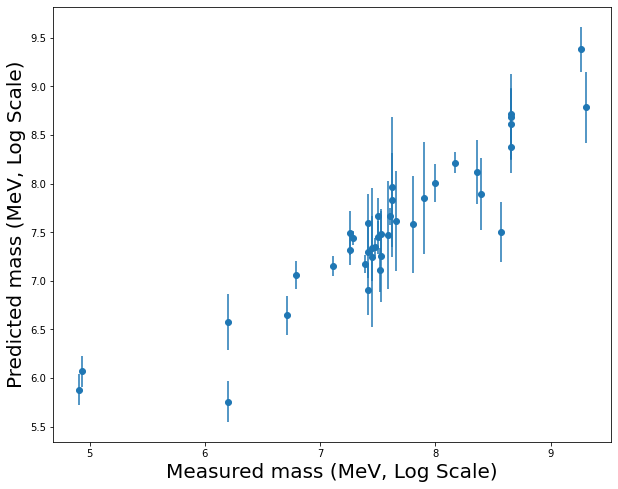

Current hyperparams: 
 noise: 0.010000000000000002, constant_value: 0.7, length_scale: 0.7


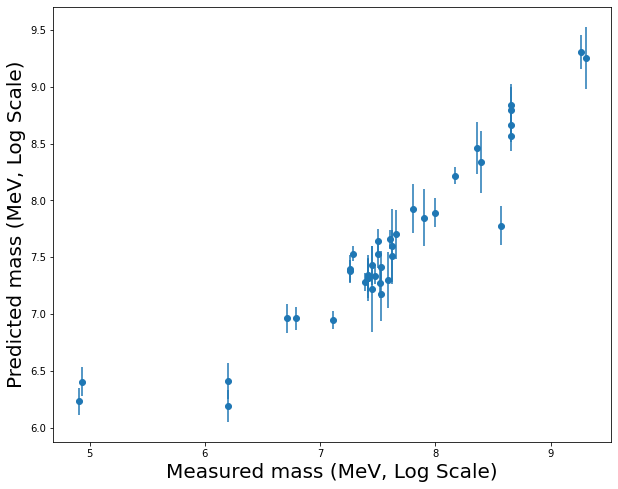

Current hyperparams: 
 noise: 0.022500000000000006, constant_value: 0.7999999999999999, length_scale: 0.7999999999999999


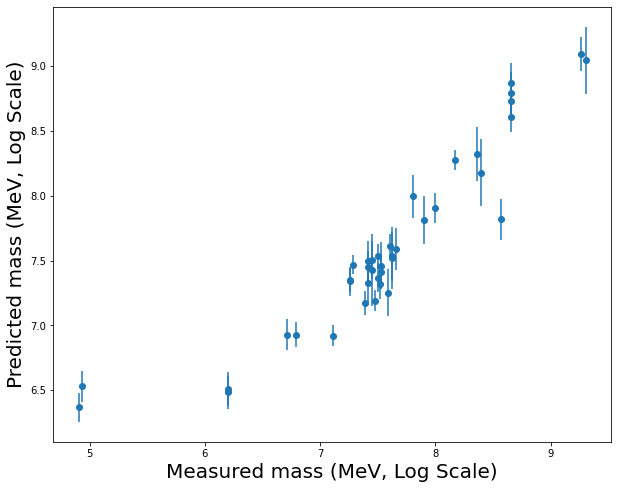

Current hyperparams: 
 noise: 0.04000000000000001, constant_value: 0.8999999999999999, length_scale: 0.8999999999999999


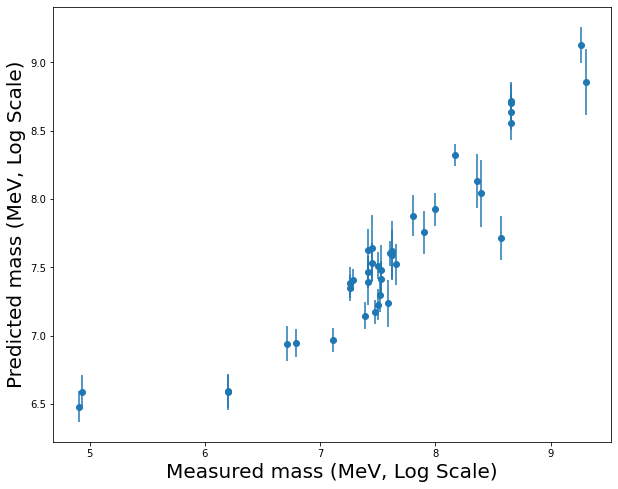

Current hyperparams: 
 noise: 0.0625, constant_value: 0.9999999999999999, length_scale: 0.9999999999999999


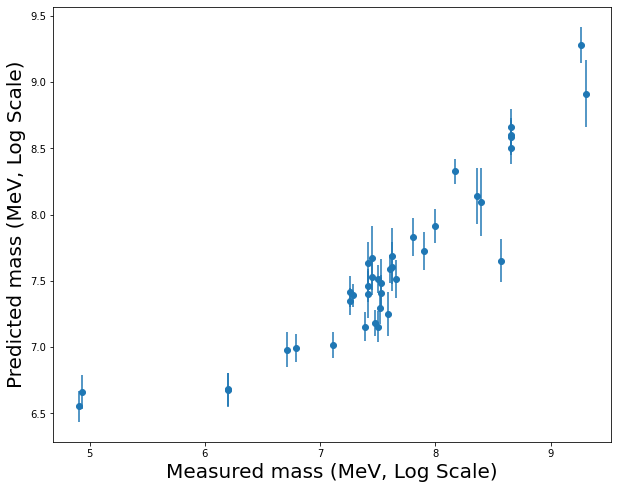

Current hyperparams: 
 noise: 0.09, constant_value: 1.0999999999999999, length_scale: 1.0999999999999999


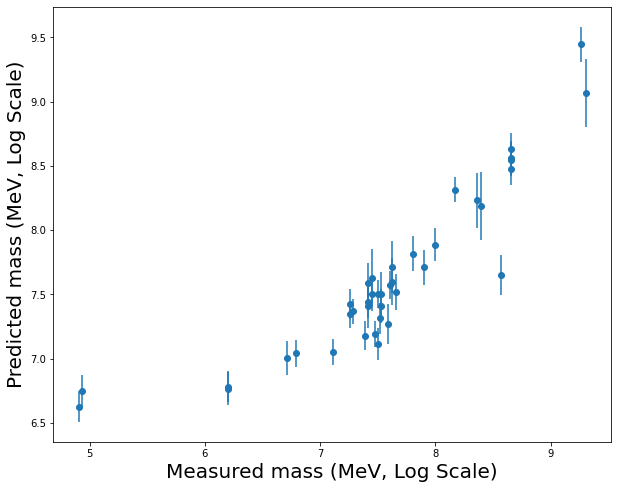

In [90]:
noise = np.arange(0.05, 0.55, 0.05)
constant_value = np.arange(0.6, 1.2, 0.1)
length_scale = np.arange(0.6, 1.2, 0.1)
# for rq kernel
alpha = np.arange(0.6, 1.2, 0.1)

hyperparams = list(zip(noise, constant_value, length_scale, alpha))

# For writing results to file
results_df = pd.DataFrame()

for counter, params in enumerate(hyperparams):
    print(f'Current hyperparams: \n noise: {params[0]**2}, constant_value: {params[1]}, length_scale: {params[2]}')

    rbf = ConstantKernel(params[1]) * RBF(length_scale=params[2])
    # rq = ConstantKernel(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)

    # Set GP prior to training data's mean and cov with kernel
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=params[0]**2, n_restarts_optimizer=10)

    gpr.fit(X_train, Y_train)
    mean, cov = gpr.predict(X_test, return_std=True)

    # Obtain optimized kernel parameters
    l = gpr.kernel_.k2.get_params()['length_scale']
    sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
    
    # Store current iteration data
    current_results_df = pd.DataFrame({'run': counter, 'measured': Y_test, 'predicted': mean, 'variance': cov,
                            'rmse': mean_absolute_error(Y_test, mean), 'alpha': params[0]**2,
                            'initial_length scale': params[2], 'initial_sigma_f': params[1],
                            'trained_length_scale': l, 'trained_sigma_f': sigma_f})
    
    # Draw plots
    plotter(Y_test, mean, cov)
    
    # Join dataframes to save 
    results_df = pd.concat([results_df, current_results_df])
    
# write to file
results_df.to_csv('results.csv', index=False)

In [77]:
results_df.shape

(40, 8)

In [89]:
def plotter(ground_truth, prediction, cov):
    # Plot the mean and variances
    fig, ax = plt.subplots(figsize=(10, 8))

    # Set font size
    FONT_MEDIUM = 20
    plt.rc('axes', labelsize=FONT_MEDIUM)    # fontsize of the x and y labelsb

    ax.scatter(ground_truth, prediction)
    ax.errorbar(ground_truth, prediction, yerr=cov, linestyle='None')
    ax.set_ylabel('Predicted mass (MeV, Log Scale)')
    ax.set_xlabel('Measured mass (MeV, Log Scale)')
    plt.show()

### LOOCV

In [11]:
# Leave-one-out
loo = LeaveOneOut()
n_splits = loo.get_n_splits(X)

l = []
mu = []
cov = []
sigma_f = []
for train_index, test_index in loo.split(X):
#     print('Train index: ', train_index, 'Test index: ', test_index)
    X_star, X_train = X[test_index], X[train_index]
    
    # Replace the Y's with Y_log, Y_normalized, or Y_noisy as needed
    Y_star, Y_train = Y_log[test_index], Y_log[train_index]
    
    # Reuse training data
    gpr.fit(X_train, Y_train)

    # Compute posterior mean and covariance
    # Y_star
    mu_s, cov_s = gpr.predict(X_star, return_std=True)
    mu.append(mu_s)
    cov.append(cov_s)
    
    print('log y_star: ', Y_star)
    print('Predicted y_star: ', mu_s)
    print('Predicted std: ', cov_s)
    print('Test index: ', test_index)
    
    # Obtain optimized kernel parameters
    l.append(gpr.kernel_.k2.get_params()['length_scale'])
    sigma_f.append(np.sqrt(gpr.kernel_.k1.get_params()['constant_value']))
    break

# Plot the results
# plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)


log y_star:  [[4.93856906]]
Predicted y_star:  [[5.76014688]]
Predicted std:  [0.32051062]
Test index:  [0]
